# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

In [2]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.head(20)

,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
5,Flossies,Flossbone,1
6,Hypnotiq,Hopnotic,1
7,Woody Stout,Woody Brown Ale,1
8,Frickin’ Chicken,Flip’n Chicken,1
9,Alair,Holaira,1


In [3]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [4]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [5]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [6]:
from abydos.phones import *

In [7]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [8]:
import re

In [9]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
#     df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [ ]:


# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

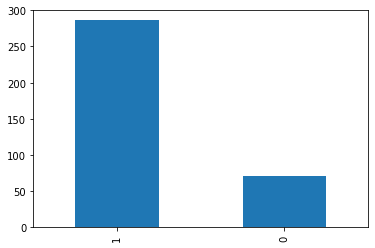

In [10]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [11]:
from itertools import combinations
import random
random.seed(42)


In [89]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=300), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

,TM_A,TM_B
0,Inside,RAWPIXEL
1,Sambucks,SAVVY
2,Next Deal Shop,MONSTER ENERGY
3,PURE IPR,Camel Capa
4,WHOLE FOODS MARKET,ADVANTAGE HOLIDAYS BY ADVANTAGE
...,...,...
295,POWERING THE WORLD OF WORK,Together for Better
296,FOX,IBM
297,Cuff & Collar Cleaner,DG’S
298,GAZIANTEPLILER PASTANESI,Ldnr


In [90]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:1


In [91]:
nonmatch_cases.sample(20)

,TM_A,TM_B
51,Kuf’N Kolar,HALCYON EFFECT
81,House of Silk,ADDICTION
49,BEATRICE PERRY,Maternity Yours
134,WOMO,WECASABLANCA
281,Glenfield,GURU
183,Kuf’N Kolar,Camel activ
283,FWDVIEW,AADVANTAGE
144,Wolf,RAWPIXEL
68,CANDEY,HORIZON RISK SOLUTIONS
286,WELLBLOCKS,DG FASHION


In [92]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

class_balanced

# class_balanced[class_balanced['TM_B'].str.len()!=0]


,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
...,...,...,...
352,Lilton,Wilton,0
353,Nutricia,Nutritea,0
354,Glenreidh,An Reidhe,0
355,No Gunk No Junk,No Gunk Just Funk,0


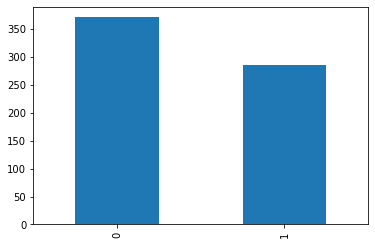

In [93]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [94]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,metaphone,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
117,Tatadoo,Potters,0,tatadoo,potters,29,29,29,0.193548,0,...,0.000000,0.428571,0.000000,0.314286,0.523810,0.194444,0.142857,0.743137,0.458537,0.658986
187,GENIE,JOBZGENIE,1,genie,jobzgenie,100,71,71,0.129032,0,...,0.000000,0.555556,0.241379,0.555556,0.437037,0.454365,0.555556,0.752941,0.489362,0.555556
31,ANGEL’S ENVY,+ Class View,0,angelsenvy,classview,33,32,32,0.290323,0,...,0.000000,0.150000,0.000000,0.250000,0.551852,0.166900,0.300000,0.768137,0.398148,0.679032
105,Snakeman,BOOHOO,0,snakeman,boohoo,0,0,0,0.258065,0,...,0.000000,0.187500,0.000000,0.137500,0.000000,0.000000,0.000000,0.666667,0.154545,0.572581
332,WOOLLY AND TIG,WOOZLE & PIP,0,woollyandtig,woozlepip,44,48,48,0.225806,0,...,0.000000,0.541667,0.156250,0.529167,0.657407,0.392424,0.416667,0.828431,0.502479,0.700269
3,PURE IPR,Camel Capa,0,pureipr,camelcapa,29,25,25,0.225806,0,...,0.000000,0.333333,0.000000,0.311111,0.502646,0.208333,0.222222,0.775490,0.268085,0.641577
119,Tatadoo,TATA,1,tatadoo,tata,100,73,73,0.096774,0,...,0.833333,0.714286,0.409091,0.800000,0.857143,0.490476,0.571429,0.982353,0.606061,0.571429
266,WILDWOOD KITCHEN,WILD AND WOOD COFFEE HOUSE,1,wildwoodkitchen,wildandwoodcoffeehouse,60,59,59,0.419355,0,...,0.666667,0.590909,0.209677,0.643182,0.698485,0.366546,0.454545,0.986275,0.487324,0.642962
164,SKYRIZI,THE POWER OF SIMPLICITY,0,skyrizi,thepowerofsimplicity,43,22,22,0.548387,0,...,0.000000,0.225000,0.000000,0.342500,0.526190,0.000000,0.050000,0.838725,0.201923,0.328226
34,POST-IT,Hajdu Halloumi,0,postit,hajduhalloumi,36,21,21,0.387097,0,...,0.000000,0.269231,0.000000,0.346154,0.000000,0.000000,0.000000,0.680392,0.179104,0.397022


#### Export clean data to csv

In [ ]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [95]:
y = df.target
X = df.drop(columns = 'target')

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [ ]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [99]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

,target,partial,tkn_sort,tkn_set,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,1,57,50,50,0.161290,0,0,0,0,0.485480,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,1,38,38,38,0.161290,0,0,0,0,0.050000,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,1,89,73,73,0.096774,0,0,0,0,0.821263,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,1,83,83,83,0.096774,0,0,0,1,0.884677,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,1,74,65,65,0.290323,0,0,0,0,0.951613,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0,83,83,83,0.032258,0,0,0,0,0.897436,...,0.833333,0.833333,0.500000,0.833333,0.822222,0.833333,0.833333,0.866667,0.823529,0.943548
353,0,75,75,75,0.064516,0,0,0,1,0.804167,...,0.833333,0.812500,0.565217,0.787500,0.833333,0.750000,0.750000,0.997549,0.937500,0.973790
354,0,80,71,71,0.129032,0,0,0,0,0.800858,...,0.666667,0.666667,0.310345,0.666667,0.741402,0.588889,0.666667,0.784804,0.705882,0.655914
355,0,67,77,77,0.161290,0,0,0,1,0.852383,...,0.833333,0.678571,0.469388,0.700000,0.815873,0.637363,0.714286,0.995588,0.713415,0.808756


In [100]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1])

In [101]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [102]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.4089902361858951,
 0.6726908376534118,
 0.17926659941704104,
 0.6237662730355311,
 0.1624292949400227,
 0.6533745010838848,
 0.7053568149928229,
 0.19721103221563815,
 0.6844220144519545,
 0.7051811813740526,
 0.19233820083879552,
 0.6415761572625466,
 0.6752755076780786,
 0.16608351082129122,
 0.1631516321269136,
 0.1624292949400227,
 0.1624292949400227,
 0.1624292949400227,
 0.7062679096451815,
 0.672661906178391,
 0.6619663804272805,
 0.6589482767213394,
 0.7558882810480432,
 0.16653056350728176,
 0.1624292949400227,
 0.26666303490524484,
 0.6661517270998943,
 0.1624292949400227,
 0.1624292949400227,
 0.2019901905660703,
 0.7446927136532752,
 0.7263645547527621,
 0.1624292949400227,
 0.5947997406762089,
 0.7431125585457435,
 0.5498630468906165,
 0.6560179947328721,
 0.5744052109550669,
 0.7462823303822262,
 0.6337225012752975,
 0.28987623915169686,
 0.1624292949400227,
 0.7444835361486578,
 0.1624292949400227,
 0.7095829397539226,
 0.287543153545327,
 0.6962882422191421,
 0.74013

## K-fold cross validation

In [103]:
from sklearn.model_selection import StratifiedKFold

In [104]:
# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-104-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

completed fold 1 of 10
completed fold 2 of 10


<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-104-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

completed fold 3 of 10
completed fold 4 of 10


<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-104-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

completed fold 5 of 10
completed fold 6 of 10


<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-104-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
<ipython-input-104-7ed514384f19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oof_pred['target'] = y_test.tolist()
<ipython-input-104-7ed514384f19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [105]:
meta_training.sample(20)


,TM_A,TM_B,predict_proba,target
105,snakeman,boohoo,0.169931,0
131,eponim,tlclive,0.164691,0
213,silarom,symarom,0.690551,1
135,leciphol,lepicol,0.660384,1
269,hardcoresafetyfootwear,hardcore,0.727665,1
60,kerv,sky,0.170187,0
58,bubblefinance,bubble,0.756705,1
159,multivox,reddragon,0.168561,0
297,cuffcollarcleaner,dgs,0.209460,0
117,cambridge,cambridgeneurotech,0.749047,1


### Meta-Model: Logistic Regression

In [106]:
df=featurize(meta_training)

In [107]:
df.sample(20)

,a,b,predict_proba,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
93,snakeman,whealthhealthistherealwealth,0.168415,0,snakeman,whealthhealthistherealwealth,38,22,22,0.806452,...,0.000000,0.303571,0.000000,0.408929,0.382937,0.000000,0.035714,0.727451,0.090541,0.260945
349,vapo,vapods,0.729639,0,vapo,vapods,100,80,80,0.064516,...,0.666667,0.666667,0.476190,0.766667,0.888889,0.633333,0.666667,0.984314,0.588235,0.666667
169,drwolff,multibus,0.167642,0,drwolff,multibus,14,13,13,0.258065,...,0.000000,0.125000,0.000000,0.125000,0.422619,0.052778,0.125000,0.733333,0.411364,0.653226
74,harleyacademy,harleyclinic,0.606308,1,harleyacademy,harleyclinic,58,56,56,0.193548,...,0.500000,0.615385,0.131579,0.630769,0.707265,0.538462,0.538462,0.992157,0.715625,0.821340
263,fizzfitness,tlctraining,0.169907,0,fizzfitness,tlctraining,27,27,27,0.322581,...,0.000000,0.181818,0.000000,0.300000,0.404040,0.166667,0.181818,0.623039,0.344615,0.782991
17,hcp,ae,0.170636,0,hcp,ae,0,0,0,0.096774,...,0.000000,0.166667,0.000000,0.233333,0.000000,0.000000,0.000000,0.808333,0.000000,0.392473
72,dylan,greyfamouslyeffective,0.167762,0,dylan,greyfamouslyeffective,40,15,15,0.612903,...,0.000000,0.214286,0.000000,0.307143,0.469841,0.000000,0.095238,0.816667,0.154206,0.227343
248,sub,be,0.271224,0,sub,be,50,40,40,0.096774,...,0.833333,0.166667,0.000000,0.200000,0.000000,0.166667,0.333333,0.747059,0.411765,0.537634
207,searchsavvypr,permanize,0.180918,0,searchsavvypr,permanize,33,27,27,0.322581,...,0.000000,0.423077,0.000000,0.469231,0.410256,0.187296,0.230769,0.651961,0.286667,0.576923
171,togetherforbetter,alltogetherbetter,0.705764,1,togetherforbetter,alltogetherbetter,90,82,82,0.193548,...,0.666667,0.705882,0.519231,0.726471,0.834734,0.683626,0.823529,0.682353,0.757895,0.833017


### Evaluate Gradient Boosting Classifier

In [113]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[33  4]
 [ 4 24]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        37
           1       0.86      0.86      0.86        28

    accuracy                           0.88        65
   macro avg       0.87      0.87      0.87        65
weighted avg       0.88      0.88      0.88        65



In [109]:
# df_confusion.to_csv('TM_GBC_Confusion_matris.csv')

In [114]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.926')

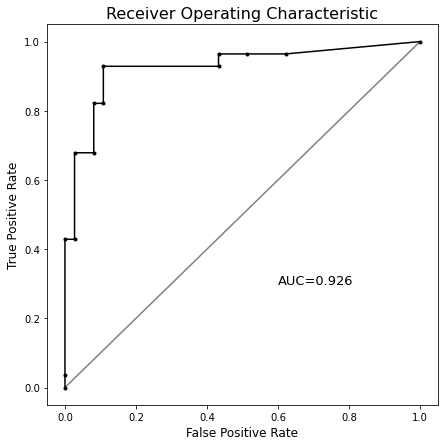

In [115]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

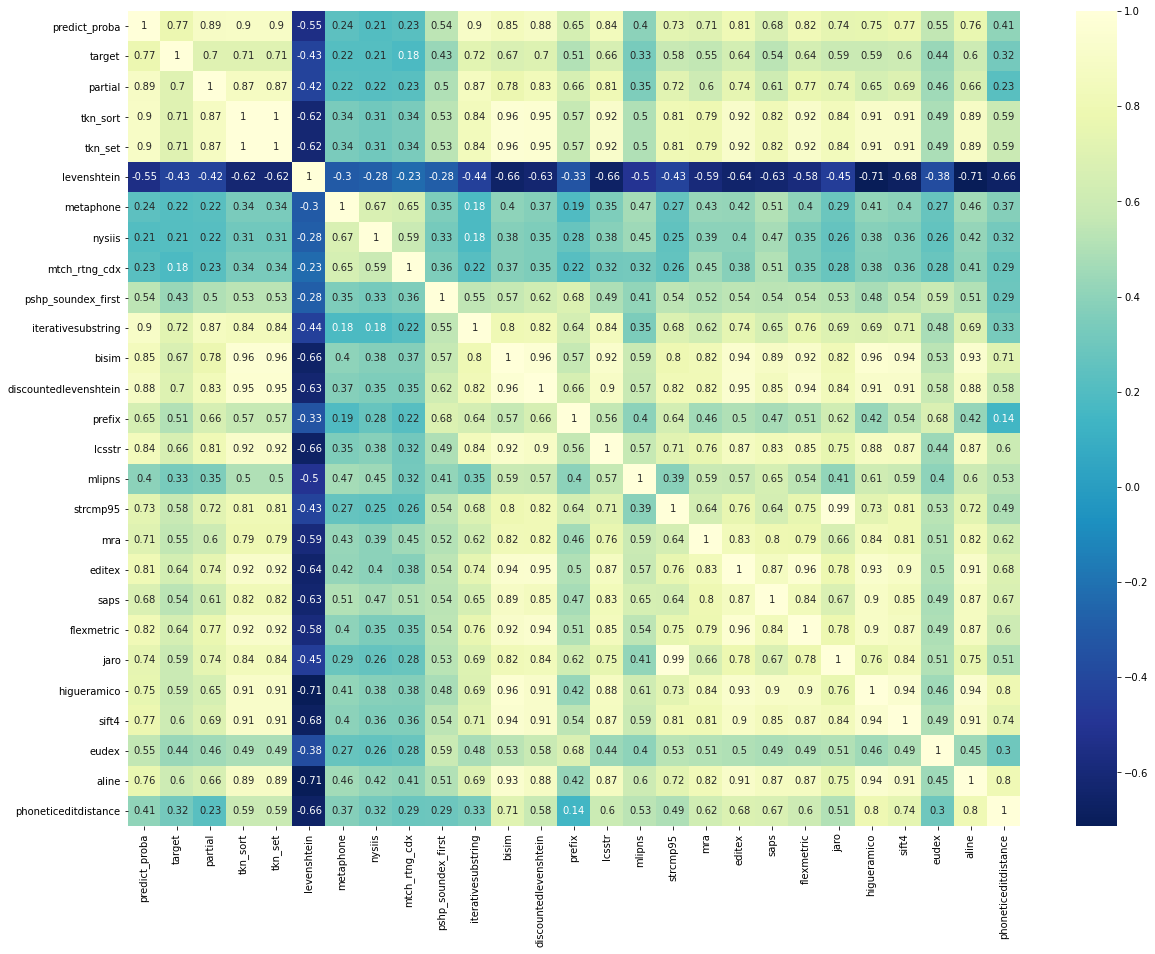

In [116]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Grid Search   

Hyperparameter tuning?

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(